# Stage II length binned gradient boosting classifier

Now we need to figure out how to combine the fragment class probabilities coming from each stage I bin into a single prediction.

To help with thinking about the problem, let's draw a diagram for the first two stage I bins:

```text

Fragment length (words): 1   5   10  15  25  30  35  40  45  50  55  60  65  70  75  80  85  90  95  100 105
                         +---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+
                 bin 50: |1                                50|                   |                   |
                         +-----------------------------------+                   |                   |
                 bin 75:                  |26                                  75|                   |
                                          +--------------------------------------+                   |
                bin 100:                                      |51                                 100|
                                                              +--------------------------------------+
```

OK, cool, that helped. So ignoring the start and end of the range where we will have some fragments that are only scored by one classifier, the solution is easy, the stage II classifier is a second set of models which each take a length range equal to each overlap between the stage I bins. So for example, here's how it would work for a fragment of length 36:

1. Fragment gets scored by stage I bin 50 classifier.
2. Fragment gets scored by stage I bin 75 classifier.
3. Score from each classifier becomes new feature, maybe 'short score' and 'long score' or something similar.
4. Dual scored fragment is sent to a second stage '26-50' classifier that takes all of the features, including the short and long scores from the stage I classifiers, to predict a final class probability. Bang. Done.

Only other edge cases are fragments that are below 26 words or above 275 words. These are only scored by the stage I classifier for their bin and that class probability is used to make the call. For production, we can send a warning about short fragments with the prediction and for 'too long' fragments we can split and/or sample, something like that. Easy.

## 1. Run setup

In [1]:
# Change working directory to parent so we can import as we would from main.py
print(f'Working directory: ', end = '')
%cd ..

import h5py
import pickle
import pandas as pd

from scipy.stats import uniform, randint
from sklearn.metrics import make_scorer

import configuration as config
import functions.notebook_helper as helper_funcs
import functions.notebook_plotting as plot_funcs
import functions.length_binned_xgboost as xgb_funcs

Working directory: /mnt/arkk/llm_detector/classifier


Set some run parameters and filepaths:

In [2]:
# Data to work with
dataset_name = 'falcon-7b_scores_v2_10-300_words'

# H5py dataset path
input_file = f'{config.DATA_PATH}/{dataset_name}_stage_II.h5'

# Number of folds to run for cross validation
cv_folds = 7

# Number of parameter sets to sample for hyperparameter optimization
hyperparameter_iterations = 100

# Paths to save and load results
cross_validation_results_filename = f'{config.DATA_PATH}/stage_two_cross_validation_results_{cv_folds}_folds.pkl'
hyperparameter_optimization_results_filename = f'{config.DATA_PATH}/stage_two_hyperparameter_optimization_results_{hyperparameter_iterations}_iterations.pkl'

OK, I think we are ready, let's do the cross-validation.

### 5.2. Cross-validation

In [3]:
# H5py dataset path
input_file = f'{config.DATA_PATH}/{dataset_name}_stage_II.h5'

# Dictionary to hold testing/experimentation results
parsed_results = {
    'Fold': [],
    'Condition': [],
    'Optimized': [],
    'Accuracy (%)': [],
    'False positive rate': [],
    'False negative rate': [],
    'Binary cross-entropy': []
}

# Make evaluation metrics scorers
scoring_funcs = {
    'negated_binary_cross_entropy': make_scorer(helper_funcs.negated_binary_cross_entropy),
    'binary_cross_entropy': make_scorer(helper_funcs.binary_cross_entropy), 
    'accuracy': make_scorer(helper_funcs.percent_accuracy),
    'false_positive_rate': make_scorer(helper_funcs.false_positive_rate),
    'false_negative_rate': make_scorer(helper_funcs.false_negative_rate)
}

# Plots to draw
plots = ['Accuracy (%)', 'False positive rate', 'False negative rate', 'Binary cross-entropy']

Cross-validating bin_026_050
Cross-validating bin_051_075
Cross-validating bin_076_100
Cross-validating bin_101_125
Cross-validating bin_126_150
Cross-validating bin_151_175
Cross-validating bin_176_200
Cross-validating bin_201_225
Cross-validating bin_226_250
Cross-validating bin_251_275


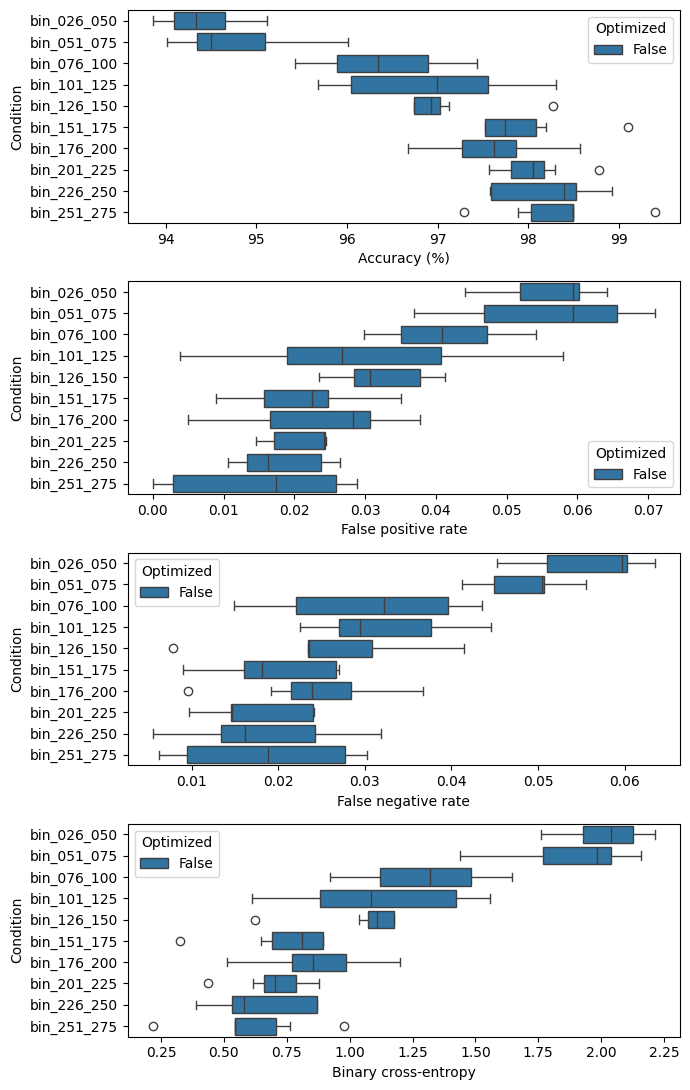

CPU times: user 2.86 s, sys: 1.65 s, total: 4.5 s
Wall time: 10.6 s


In [4]:
%%time

# Do the cross-validation
parsed_results = xgb_funcs.cross_validate_bins(
    input_file = input_file,
    parsed_results = parsed_results,
    scoring_funcs = scoring_funcs,
    cv_folds = cv_folds,
    shuffle_control = False
)

# Save the result
with open(cross_validation_results_filename, 'wb') as result_output_file:
    pickle.dump(parsed_results, result_output_file, protocol = pickle.HIGHEST_PROTOCOL)

# Plot the results
plot_funcs.plot_two_factor_cross_validation(plots, parsed_results).show()

### 5.3. Hyperparameter optimization

In [5]:
# Define hyperparameter distributions for randomized grid search
parameter_distributions = {
    'learning_rate': uniform(loc = 0.0001, scale = 0.9999),
    'gamma': uniform(loc = 0.0, scale = 100.0),
    'max_depth': randint(1, 100),
    'min_child_weight': uniform(loc = 0.0001, scale = 0.9999),
    'subsample': uniform(loc = 0.5, scale = 0.5),
    'reg_alpha': uniform(loc = 0.0, scale = 1.0),
    'reg_lambda': uniform(loc = 0.0, scale = 1.0),
    'n_estimators': randint(1, 100),
    'num_parallel_tree': randint(1, 50)
}

In [6]:
%%time

# Do the optimization
results = xgb_funcs.hyperparameter_optimize_bins(
    input_file = input_file,
    parameter_distributions = parameter_distributions,
    scoring_funcs = scoring_funcs,
    cv_folds = cv_folds,
    hyperparameter_iterations = hyperparameter_iterations
)

print()

Optimizing bin_026_050
Optimizing bin_051_075
Optimizing bin_076_100
Optimizing bin_101_125
Optimizing bin_126_150
Optimizing bin_151_175
Optimizing bin_176_200
Optimizing bin_201_225
Optimizing bin_226_250
Optimizing bin_251_275

CPU times: user 2min 29s, sys: 1.65 s, total: 2min 31s
Wall time: 4min 34s


In [7]:
# Save the raw result
with open(hyperparameter_optimization_results_filename, 'wb') as result_output_file:
    pickle.dump(results, result_output_file, protocol = pickle.HIGHEST_PROTOCOL)

In [8]:
# Parse the results
winners, cv_results = xgb_funcs.parse_hyperparameter_tuning_results(results)

bin_026_050 best score: -1.961502905163567
bin_051_075 best score: -1.662488880886912
bin_076_100 best score: -1.1388072037089745
bin_101_125 best score: -0.9874873655126574
bin_126_150 best score: -1.0278420489356141
bin_151_175 best score: -0.6958234245003314
bin_176_200 best score: -0.7582987818545178
bin_201_225 best score: -0.6134564587168148
bin_226_250 best score: -0.5663943301068013
bin_251_275 best score: -0.4969072806438367


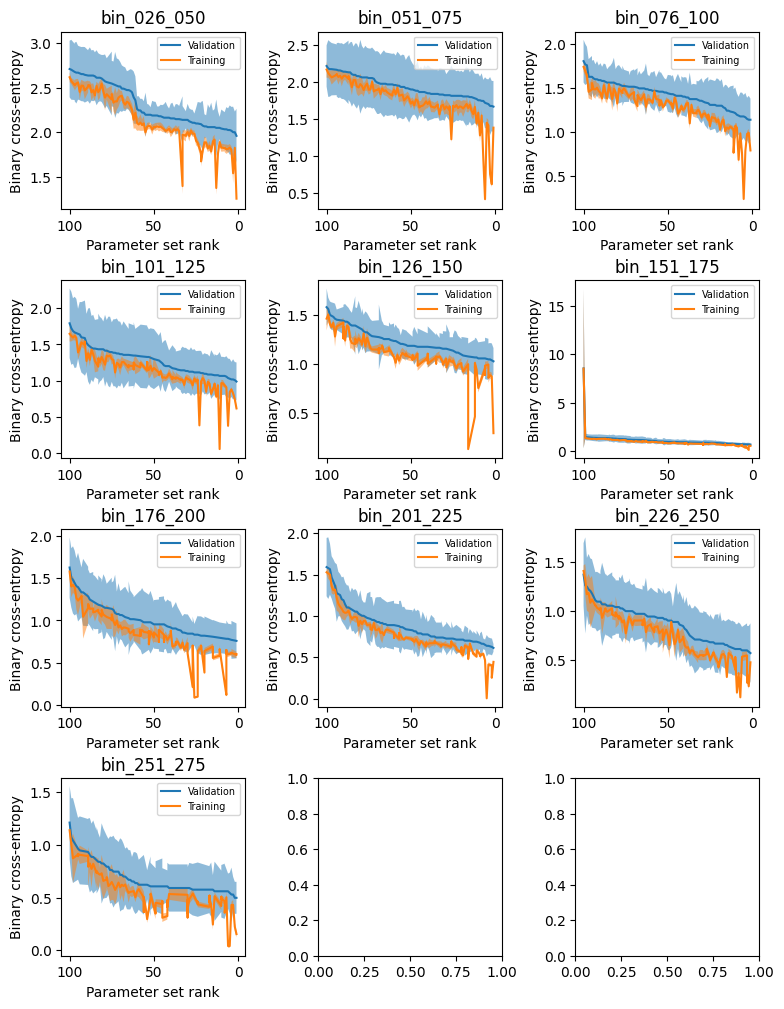

In [9]:
# Plot the results
plot_funcs.plot_hyperparameter_tuning(cv_results).show()

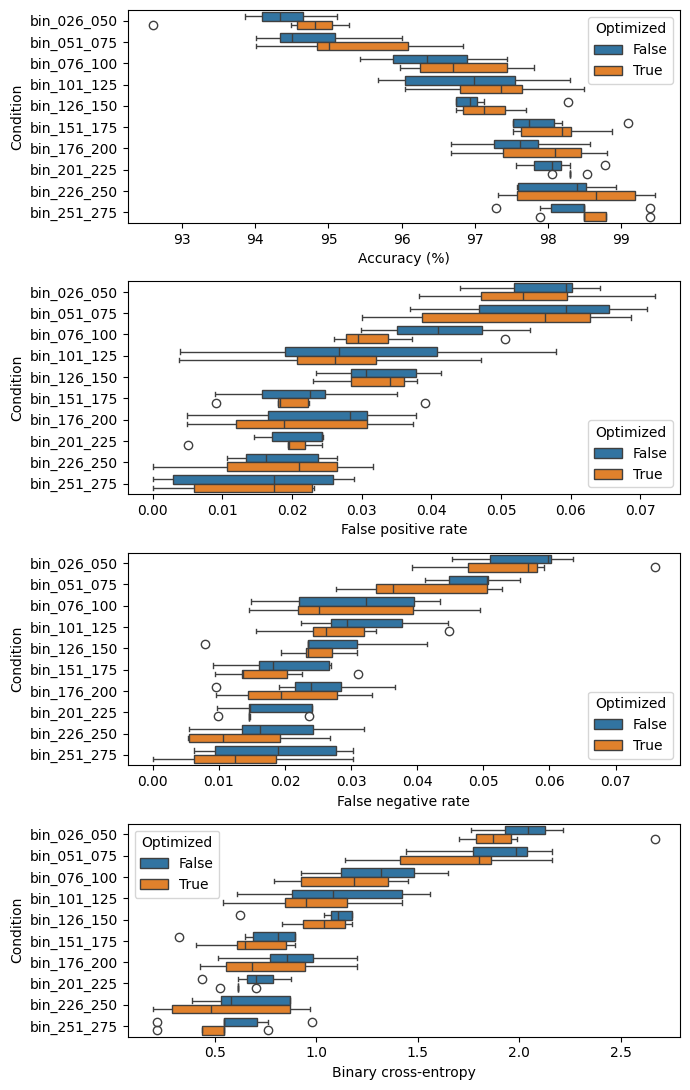

In [10]:
# Go through the hyperparameter optimization results, format and 
# add them to the results from the baseline cross-validation
parsed_results = xgb_funcs.add_winners_to_parsed_results(
    cv_results, 
    parsed_results, 
    cv_folds
)

plot_funcs.plot_two_factor_cross_validation(plots, parsed_results).show()

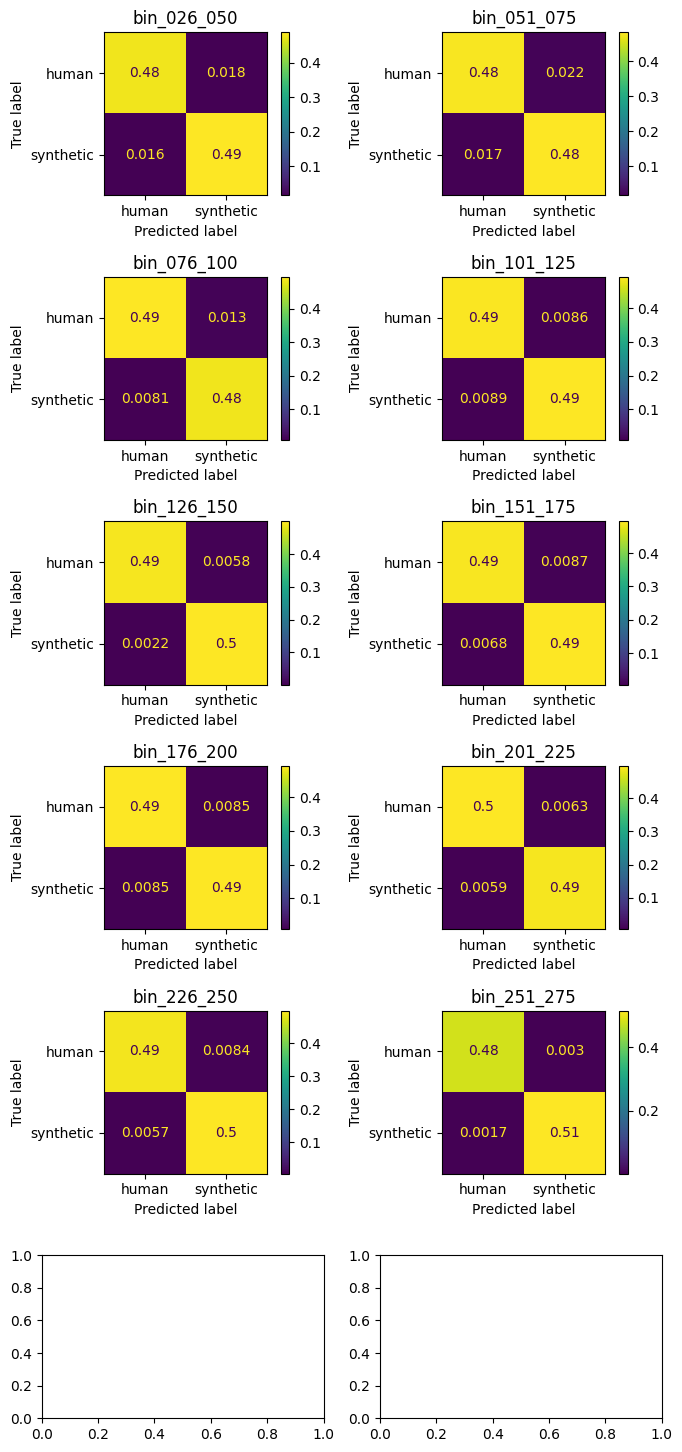

In [11]:
# Plot confusion matrix for hold-out test data in each bin
plot_funcs.plot_testing_confusion_matrices(winners, input_file).show()